What are the main indicators that influence a country’s economic development in South East Asia?
Here, we analyze the social-economic and demographic indicators of life expectancy in South East Asia , Latin America and compare them with First world countries.. 
We use regression and other machine learning techniques 
In knowing these indicators, that is where aid should be allocated. 
Reference paper:
https://www.shs-conferences.org/articles/shsconf/pdf/2021/21/shsconf_icemt2021_02006.pdf


In [ ]:
# load all the necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
import copy

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler,Normalizer
from sklearn.metrics import mean_squared_error , r2_score

warnings.filterwarnings("ignore")

In [ ]:
# mount the drive   
from google.colab import drive
drive.mount('/gdrive')
#%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
# change to the working directory
#  %cd /gdrive/MyDrive/DSKU
# Ron
%cd /gdrive/MyDrive/2023_DSKUS/EDA 
# for seunggil

/gdrive/MyDrive/2023_DSKUS/EDA


In [ ]:
# %ls /gdrive/MyDrive/2023_DSKUS/EDA

In [ ]:
%pwd

'/gdrive/MyDrive/2023_DSKUS/EDA'

In [ ]:
col_L = ['Country Name','Country Code','Series Name','Series Code','1960','1961', '1962','1963','1964','1965',\
         '1966','1967','1968','1969','1970','1971','1972','1973','1974','1975','1976','1977','1978','1979',\
         '1980','1981','1982','1983','1984','1985','1986','1987','1988','1989','1990','1991',\
         '1992','1993','1994','1995','1996','1997','1998','1999','2000','2001','2002','2003',\
         '2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015',\
         '2016','2017','2018','2019','2020','2021','2022']

### Helper functions

In [ ]:
df=pd.DataFrame()
df_c=pd.DataFrame()

In [ ]:
# helper functions
def deriveDataFrame(pd_df=df, CountryCode="KHM"):
  """Function that returns a data frame 
  after filtering by country code"""
  boolean_v = (pd_df["Country Code"] == CountryCode)
  return pd_df.where(boolean_v)

In [ ]:
def derivedTransformed_df(df_c=df_c):
  transposed_df_c = df_c.transpose()
  # get the column headers
  column_header_c = transposed_df_c.iloc[2]
  
  # update dataframe to only include rows after the first row.
  # we skip row 3 since they are just codes
  transposed_df_Cambodia = transposed_df_c[4:]
  # set the dataframe column names as the new header variable
  transposed_df_Cambodia.columns = column_header_c
  transposed_df_Cambodia.index.names = ['Year']
  return transposed_df_Cambodia

# Load the data into the data frame

In [ ]:
# thus needs to be corrected
#df = pd.read_csv("datasets/Cambodia-Thailand-Malaysia.csv", sep="|") WorldDevelopmentIndicators
df = pd.read_csv("datasets/WorldDevelopmentIndicators.csv", sep=",", encoding = 'utf8') 
#df.columns = colnames
df.head()

,Country Name,Country Code,Series Name,Series Code,1960 [YR1960],1961 [YR1961],1962 [YR1962],1963 [YR1963],1964 [YR1964],1965 [YR1965],...,2013 [YR2013],2014 [YR2014],2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018],2019 [YR2019],2020 [YR2020],2021 [YR2021],2022 [YR2022]
0,Bangladesh,BGD,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.ZS,..,..,..,..,..,..,...,15.8,17.1,18.3,19.3,20.6,21.9,23.4,25,..,..
1,Bangladesh,BGD,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.RU.ZS,..,..,..,..,..,..,...,3.5,4,4.6,5.2,5.89999999999999,6.69999999999999,7.5,8.5,..,..
2,Bangladesh,BGD,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.UR.ZS,..,..,..,..,..,..,...,47.8,49.45,50.8,52.4,53.8,55.3,56.5,58,..,..
3,Bangladesh,BGD,Access to electricity (% of population),EG.ELC.ACCS.ZS,..,..,..,..,..,..,...,61.5,62.4000015258789,74.9037399291992,75.9199981689453,88,91.8000030517578,92.1999969482422,96.1999969482422,..,..
4,Bangladesh,BGD,"Access to electricity, rural (% of rural popul...",EG.ELC.ACCS.RU.ZS,..,..,..,..,..,..,...,48.5877647399902,48.1212005615234,65.2221298217773,66.1436462402344,81.5710296630859,89.0830078125,88.8535995483398,95.2119674682617,..,..


In [ ]:
df['Country Name'].unique()

array(['Bangladesh', 'Belize', 'Thailand', 'Singapore', 'Philippines',
       'Nicaragua', 'Myanmar', 'Mexico', 'Malaysia', 'Cambodia',
       'Indonesia', 'Guatemala', 'Haiti', 'El Salvador', 'Ecuador',
       'Dominica', 'Cuba', 'Costa Rica', 'Colombia', 'Vietnam'],
      dtype=object)

In [ ]:
transposed_df_Malaysia = pd.DataFrame()
def getTheStringColumns(transposed_df_Malaysia):
  nonNullIndicators = []
  Indicators_L = list(transposed_df_Malaysia.columns.values.tolist())
  for i in range(len(Indicators_L)):
    #if Indicators_L[i] != list(transposed_df_Cambodia[nan].columns)[0]:
    if isinstance(Indicators_L[i], float):
      pass
    else:
      nonNullIndicators.append(Indicators_L[i])
  return nonNullIndicators

In [ ]:
# helper functions
def deriveDataFrame(pd_df=df, CountryCode="KHM"):
  """Function that returns a data frame 
  after filtering by country code"""
  boolean_v = (pd_df["Country Code"] == CountryCode)
  return pd_df.where(boolean_v)

In [ ]:

#columns_L = df_Cambodia.columns.values.tolist()
#columm_str_L = columns_L[0:4]
#date_cols = [col[0:4] for col in columns_L[4:]]
# join the column strings together with the dates
#cols_L = columm_str_L + date_cols
#cols_L

In [ ]:
countries = {}
countries['BGD'] = 'Bangladesh' #not SEA
countries['BLZ'] = 'Belize' # population is small
countries['THA'] = 'Thailand' # ok 
countries['SGP'] = 'Singapore' # don't need foreign aid
countries['PHL'] = 'Philippines' # ok
countries['NIC'] = 'Nicaragua' # ok
countries['MMR'] = 'Myanmar' # ok
countries['MEX'] = 'Mexico' # need to discuss; don't need foreign aid?
countries['MYS'] = 'Malaysia' # ok
countries['KHM'] = 'Cambodia' # ok
countries['IDN'] = 'Indonesia' # ok
countries['GTM'] = 'Guatemala' ## ok
countries['HTI'] = 'Haiti' # population is small
countries['SLV'] = 'El Salvador' ## ok
countries['ECU'] = 'Ecuador' # ok
countries['DMA'] = 'Dominica' # need to discuss; population is small?
countries['CUB'] = 'Cuba' ## ok
countries['CRI'] = 'Costa Rica' # population is small
countries['COL'] = 'Colombia' # ok
countries['VNM'] = 'Vietnam'# ok
#Brunei, Timor-Leste, Lao PDR, 
#Argentina, Bolivia, Brazil, Chile, Guyana,
#Paraguay, Peru, Suriname, Uruguay, "Venezuela, RB"


In [ ]:
dataframe_L = []
country_codes_L = list(df['Country Code'].unique())
dataframe_collection = {} 
for cc in range(len(country_codes_L)):
  country_name = countries[country_codes_L[cc]]
  df_str = 'df_' + country_name

  boolean_v = (df["Country Code"] == country_codes_L[cc])
  df_str = df.where(boolean_v)
  df_str.columns = col_L
  #df_str['country_name'] = country_name
  #df_str['country_code'] = country_codes_L[cc]
  df_m = df_str.copy()
  transposed_df_country = derivedTransformed_df(df_m)

  nonNullIndicators = getTheStringColumns(transposed_df_country)
  transposed_df_countryNonCols = transposed_df_country[nonNullIndicators]
  transposed_df_countryNonCols_cc = transposed_df_countryNonCols.copy()
  transposed_df_countryNonCols_cc['country_name'] = country_name
  transposed_df_countryNonCols_cc['country_code'] = country_codes_L[cc]
  dataframe_collection[country_name] = transposed_df_countryNonCols_cc

In [ ]:
dataframe_collection['Thailand'].head()

Series Name,Access to clean fuels and technologies for cooking (% of population),"Access to clean fuels and technologies for cooking, rural (% of rural population)","Access to clean fuels and technologies for cooking, urban (% of urban population)",Access to electricity (% of population),"Access to electricity, rural (% of rural population)","Access to electricity, urban (% of urban population)",Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+),"Account ownership at a financial institution or with a mobile-money-service provider, female (% of population ages 15+)","Account ownership at a financial institution or with a mobile-money-service provider, male (% of population ages 15+)","Account ownership at a financial institution or with a mobile-money-service provider, older adults (% of population ages 25+)",...,Women who believe a husband is justified in beating his wife when she burns the food (%),Women who believe a husband is justified in beating his wife when she goes out without telling him (%),Women who believe a husband is justified in beating his wife when she neglects the children (%),Women who believe a husband is justified in beating his wife when she refuses sex with him (%),Women who were first married by age 15 (% of women ages 20-24),Women who were first married by age 18 (% of women ages 20-24),Women's share of population ages 15+ living with HIV (%),Young people (ages 15-24) newly infected with HIV,country_name,country_code
Year,,,,,,,,,,,,,,,,,,,,,
1960,..,..,..,..,..,..,..,..,..,..,...,..,..,..,..,..,..,..,..,Thailand,THA
1961,..,..,..,..,..,..,..,..,..,..,...,..,..,..,..,..,..,..,..,Thailand,THA
1962,..,..,..,..,..,..,..,..,..,..,...,..,..,..,..,..,..,..,..,Thailand,THA
1963,..,..,..,..,..,..,..,..,..,..,...,..,..,..,..,..,..,..,..,Thailand,THA
1964,..,..,..,..,..,..,..,..,..,..,...,..,..,..,..,..,..,..,..,Thailand,THA


In [ ]:
#df['Country Name'].unique()

# Handling Missing values

## Calculate number of missing values

In [ ]:
print("Number of Countries :" ,len(dataframe_collection.keys()))

Number of Countries : 20


In [ ]:
a = dataframe_collection.items()

In [ ]:
print(len(a))

20


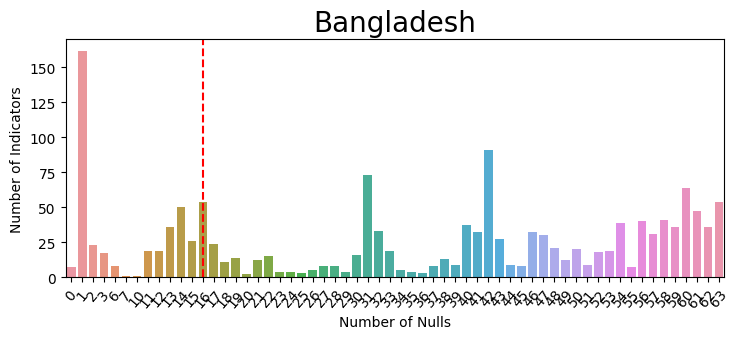

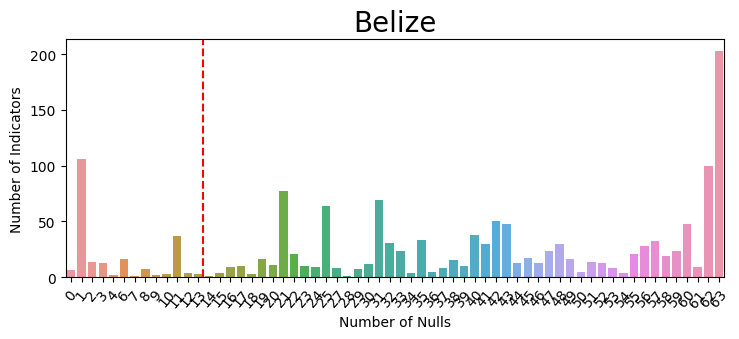

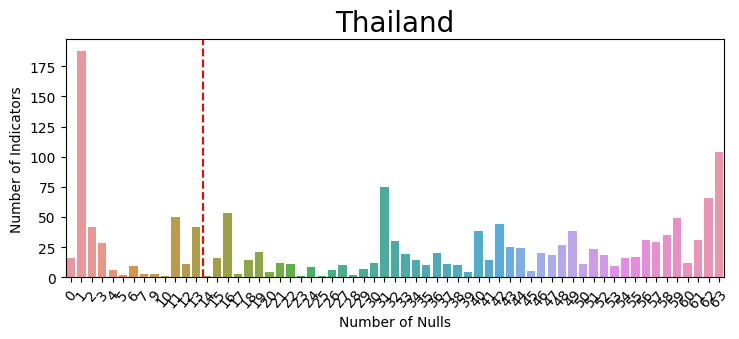

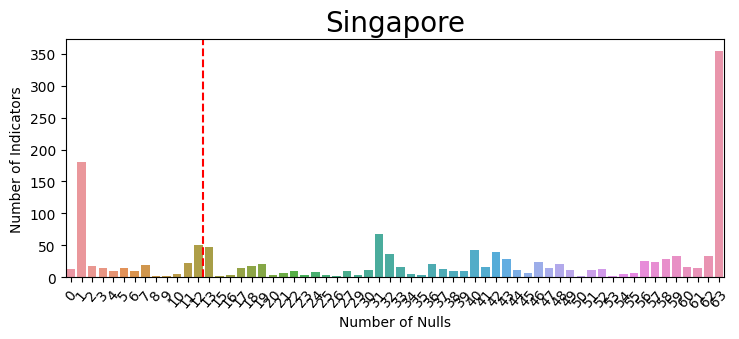

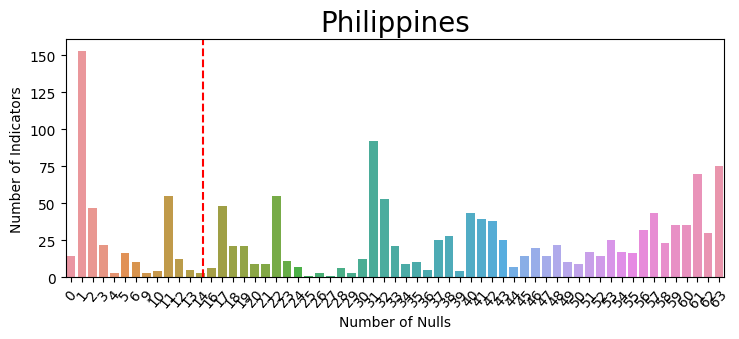

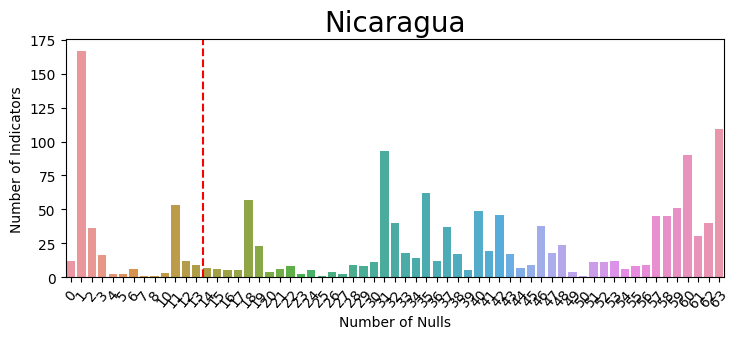

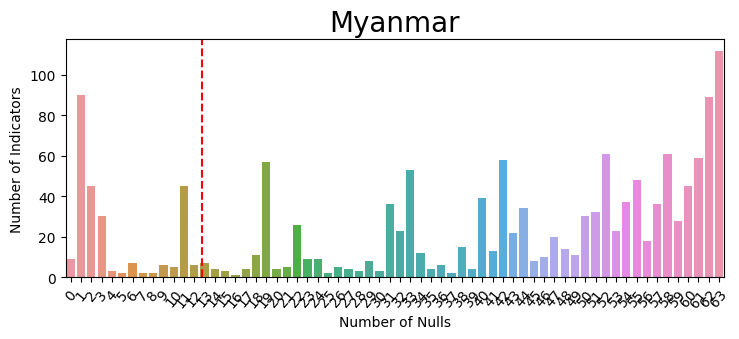

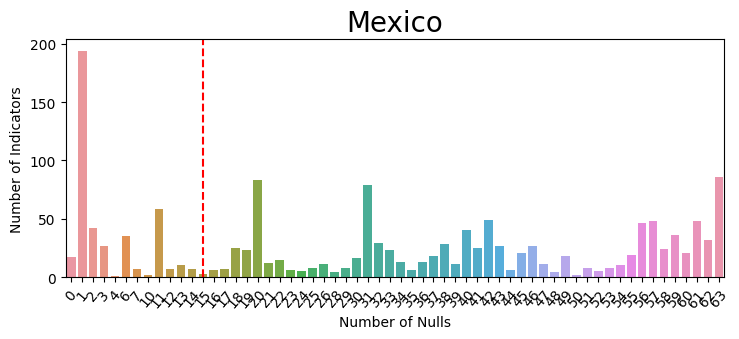

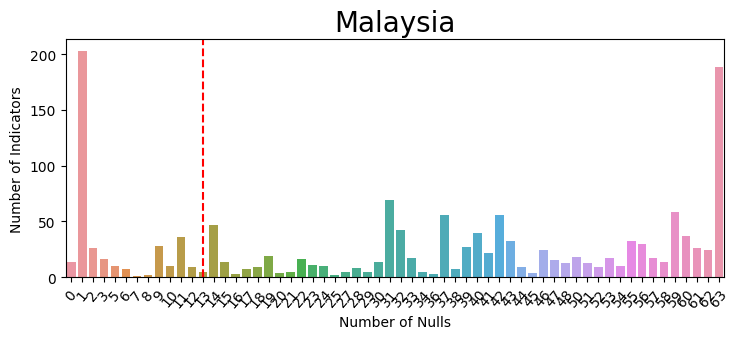

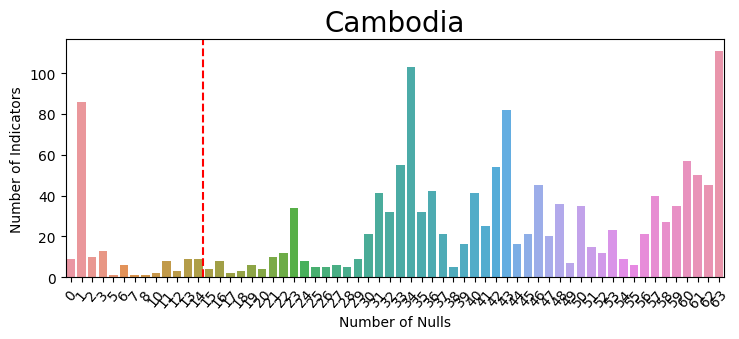

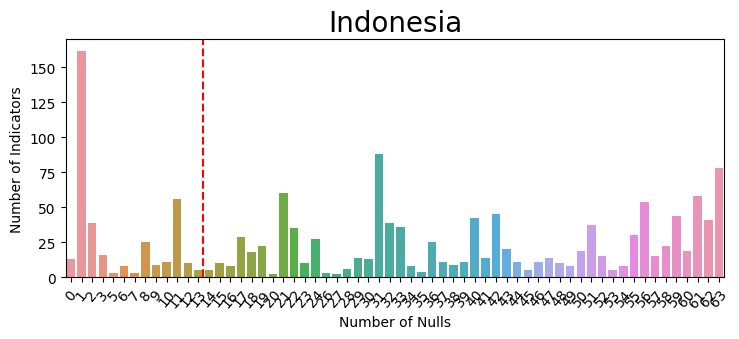

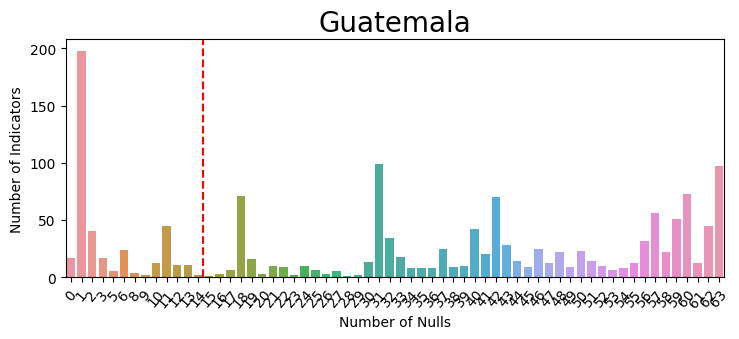

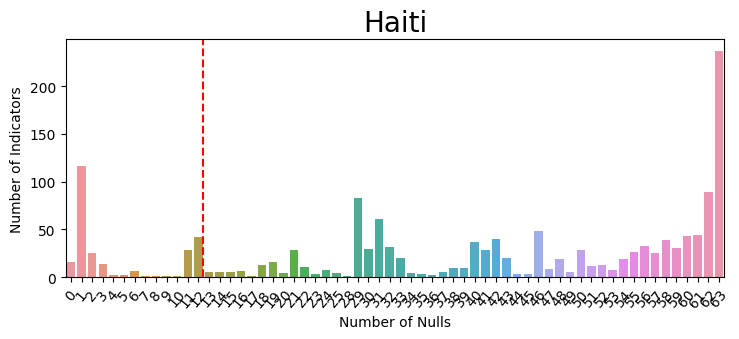

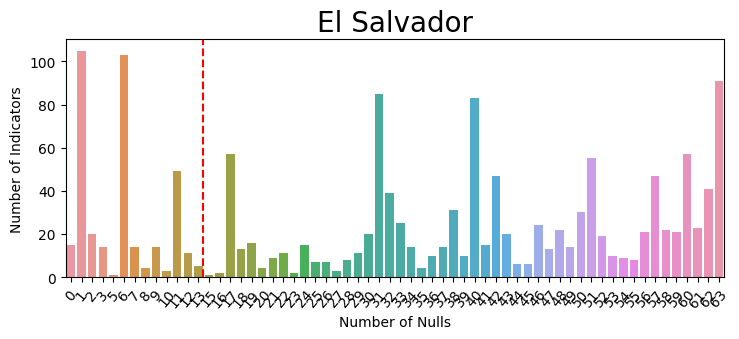

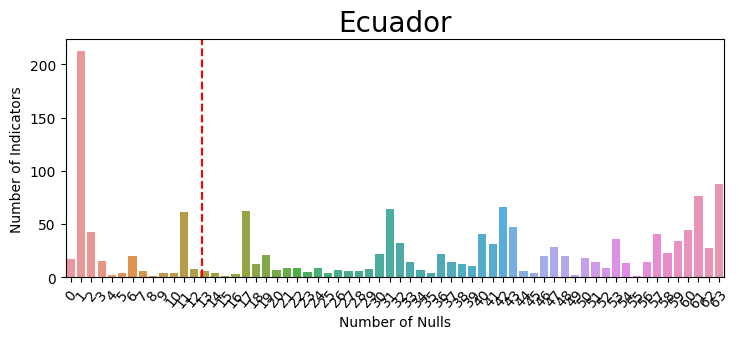

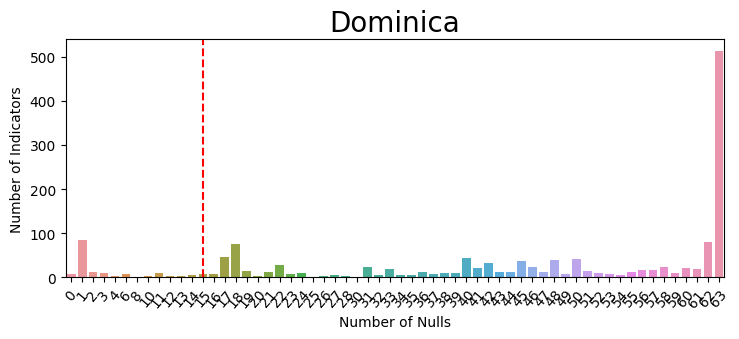

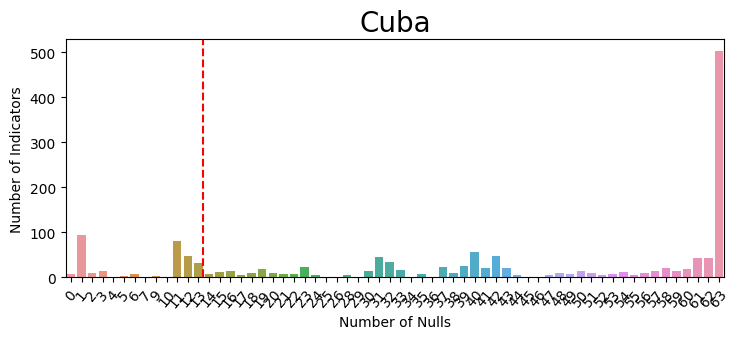

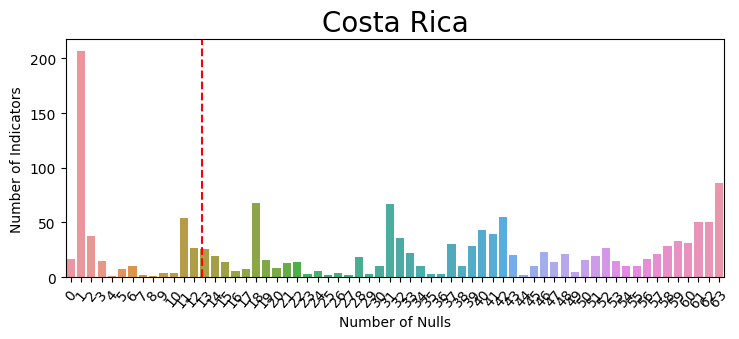

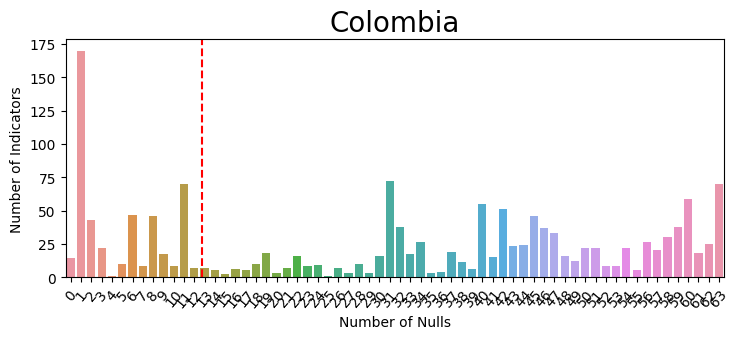

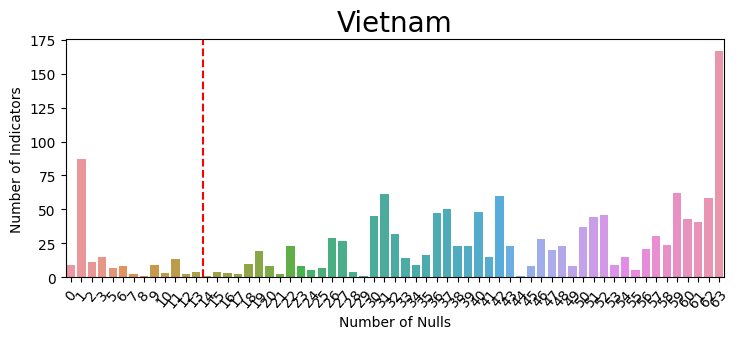

In [ ]:
cnt = 0
NULL_CRITERION = 20
# Added this code to have presentable graphs
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
for country, country_df in dataframe_collection.items():
    # replace ".." to nan
    country_df.replace("..", np.NAN, inplace=True)
    # make it to float
    # Select columns of non-excluded data types
    columns_to_convert = country_df.columns.difference(["country_name", "country_code"])

    # Convert selected columns to float
    country_df[columns_to_convert] = country_df[columns_to_convert].astype(float)

    # for plot
    
    null_counts = country_df.isnull().sum()
    num_idx_of_nulls = list(null_counts.value_counts().index)
    num_of_nulls = list(null_counts.value_counts())
    plt.title(country, fontsize=20)
    sns.barplot(x=num_idx_of_nulls, y=num_of_nulls)
    plt.xticks(rotation=50)
    plt.axvline(len(num_of_nulls) / 100 * NULL_CRITERION, linestyle = "--", color = "r")
    plt.xlabel("Number of Nulls")
    plt.ylabel("Number of Indicators")
    # Ex. 2, 22 means there are 
    # 22 indicators that have 2 nulls
    plt.tight_layout()
    plt.show()
    # cnt += 1 # only for debuging

In [ ]:
country_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 63 entries, 1960 to 2022
Data columns (total 1480 columns):
 #     Column                                                                                                                                        Dtype  
---    ------                                                                                                                                        -----  
 0     Access to clean fuels and technologies for cooking (% of population)                                                                          float64
 1     Access to clean fuels and technologies for cooking, rural (% of rural population)                                                             float64
 2     Access to clean fuels and technologies for cooking, urban (% of urban population)                                                             float64
 3     Access to electricity (% of population)                                                                

## Strategy 1.
If the 60%(or other value) or above of the column data are missing, delete this column (for all of other countries to make a “general” model)

In [ ]:
def select_missing_features(country_df):
    """
    get column name of missing value >= 60% of lengh of data
    """
    length_df = country_df.shape[0]
    criterion = length_df / 100 * NULL_CRITERION # drop feature above 20% missing value
    null_counts = country_df.isnull().sum()
    col_name_for_drop = list(null_counts[null_counts > criterion].index)
    if 'GDP (current US$)' in col_name_for_drop:
        col_name_for_drop.remove('GDP (current US$)')
    return col_name_for_drop

In [ ]:
col_name_for_drop_allcountries = []

for country, country_df in dataframe_collection.items():
    country_df.replace("..", np.NAN, inplace=True)
    col_name_for_drop_allcountries.extend(select_missing_features(country_df))

col_name_for_drop_allcountries = list(set(col_name_for_drop_allcountries)) # drop duplicates



In [ ]:
for country, country_df in dataframe_collection.items():
    # drop columns
    country_df.drop(columns = col_name_for_drop_allcountries, inplace = True)

In [ ]:
#for country, country_df in dataframe_collection.items():
#   print(country_df.shape)

## Strategy 2.
For remain missing values, try three different strategy(we’ll choose the strategy with best model performance)

###  Convert missing values to mean of column

In [ ]:
mean_dataframe_collection = copy.deepcopy(dataframe_collection)
for country, country_df in mean_dataframe_collection.items():
    column_means = country_df.mean(skipna = True)
    country_df.fillna(column_means, inplace=True)

In [ ]:
gdp_columns = [col for col in country_df.columns if 'GDP' in col]
gdp_columns

['GDP (current US$)']

### Handling with linear interpolation

In [ ]:
linear_inp_dataframe_collection = copy.deepcopy(dataframe_collection)
for country, country_df in linear_inp_dataframe_collection.items():
    linear_inp_dataframe_collection[country].interpolate(inplace=True, limit_direction='both')
    # display(linear_inp_dataframe_collection[country].head(3))

### Handling with spline interpolation
with 3rd interpolation

In [ ]:
sp_inp_dataframe_collection = copy.deepcopy(dataframe_collection)
for country, country_df in sp_inp_dataframe_collection.items():
    country_df.reset_index(inplace=True)
    sp_inp_dataframe_collection[country].interpolate(method="spline", order=3, inplace=True, limit_direction='both')
    country_df.set_index('Year', inplace=True)

# Making ML models

In [ ]:
sp_inp_dataframe_collection.keys()

dict_keys(['Bangladesh', 'Belize', 'Thailand', 'Singapore', 'Philippines', 'Nicaragua', 'Myanmar', 'Mexico', 'Malaysia', 'Cambodia', 'Indonesia', 'Guatemala', 'Haiti', 'El Salvador', 'Ecuador', 'Dominica', 'Cuba', 'Costa Rica', 'Colombia', 'Vietnam'])

In [ ]:
def make(dataframe_collection):
    """
    make the dataset for ML model for each 

    output (tuple):
        (X, y) X: feature, y: target

    """
    new_dataframe_collection = dict()
    for country, country_df in dataframe_collection.items():
        X = country_df.drop(columns = ['GDP (current US$)', 'country_name', 'country_code'])
        # adjusting feature value (dollar -> 1 trillion dollar)
        y = country_df['GDP (current US$)']  / 1_000_000_000
        new_dataframe_collection[country] = (X, y)
    return new_dataframe_collection

In [ ]:
mean_dataframe_collection = make(mean_dataframe_collection)
new_linear_inp_dataframe_collection = make(linear_inp_dataframe_collection)
new_sp_inp_dataframe_collection = make(sp_inp_dataframe_collection)

In [ ]:
new_sp_inp_dataframe_collection['Bangladesh'][1]

Year
1960      4.274894
1961      4.817580
1962      5.081413
1963      5.319458
1964      5.386055
           ...    
2018    321.379024
2019    351.238474
2020    373.902135
2021    416.264943
2022    514.250721
Name: GDP (current US$), Length: 63, dtype: float64

In [ ]:
# num of features
new_sp_inp_dataframe_collection['Bangladesh'][0].shape[1]

112

In [ ]:
NORMALIZE = False

def build(X, y):
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    tscv = TimeSeriesSplit(n_splits = 5)
    i = 1
    score = []
    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test= y.iloc[train_idx], y.iloc[test_idx]
        if NORMALIZE:
            normalizer = Normalizer()
            X_train = normalizer.fit_transform(X_train)  #x_train라는 데이터 입력
            X_test = normalizer.transform(X_test)
        model = LinearRegression()
        model.fit(X_train, y_train)
        
        pred = model.predict(X_test)
        MSE = mean_squared_error(y_test, pred) 
        r2 = r2_score(y_test, pred)
        print("R2 :", np.sqrt(r2))
        print("RMSE :", np.sqrt(MSE))

    # X_scaled = std_scaler.fit_transform(X_train)  #x_train라는 데이터 입력
    # #define cross-validation method to use
    # cv = LeaveOneOut()
    # for i, (train_index, test_index) in enumerate(tscv.split(X)):
    #     print(f"Fold {i}:")
    #     print(f"  Train: index={train_index}")
    #     print(f"  Test:  index={test_index}")
    # #build  DecisionTreeRegressor
    # model = LinearRegression()
    
    # # model.fit(X_train, y_train)

    # # pred = model.predict(X_test)

    # # MSE = mean_squared_error(y_test, pred) 
    # # print(np.sqrt(MSE))
    # # #use LOOCV to evaluate model
    # scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error',
    #                         cv=cv, n_jobs=-1)

    # # #view mean absolute error
    # print( "RMSE :", np.sqrt(np.mean(abs(scores))))
    

In [ ]:
# for country, (X, y) in mean_dataframe_collection.items():
#     build(X, y)

In [ ]:
for country, (X, y) in new_linear_inp_dataframe_collection.items():
    print(country)
    build(X, y)

Bangladesh
R2 : nan
RMSE : 238.73749756596817
R2 : nan
RMSE : 67.21395930075826
R2 : nan
RMSE : 173.4057417742633
R2 : nan
RMSE : 75.12013685537349
R2 : nan
RMSE : 112.52984012610686
Belize
R2 : nan
RMSE : 2.2120356136163632
R2 : nan
RMSE : 0.3635536142160679
R2 : nan
RMSE : 1.2140078753101045
R2 : nan
RMSE : 0.9695967707054414
R2 : nan
RMSE : 0.9772893902596922
Thailand
R2 : nan
RMSE : 31.505804019108425
R2 : nan
RMSE : 51.751009953668415
R2 : nan
RMSE : 56.77981781902781
R2 : nan
RMSE : 131.6562375506556
R2 : nan
RMSE : 806.177765739452
Singapore
R2 : 0.9865531995241437
RMSE : 0.6391992098100568
R2 : 0.8809097702901256
RMSE : 5.504586304702859
R2 : nan
RMSE : 15.549529127831136
R2 : 0.7042839441008134
RMSE : 45.60674712441686
R2 : nan
RMSE : 125.56500207441381
Philippines
R2 : nan
RMSE : 120.04890832366347
R2 : nan
RMSE : 55.98224203497653
R2 : nan
RMSE : 122.70782659311784
R2 : nan
RMSE : 156.43634591542798
R2 : nan
RMSE : 250.2712496380804
Nicaragua
R2 : nan
RMSE : 2.07322539227344

In [ ]:
# for country, (X, y) in new_sp_inp_dataframe_collection.items():
#     build(X, y)